<a href="https://colab.research.google.com/github/VelociraptorAndCo/Kozireva_Elizaveta/blob/main/GoodBoy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchsummary import summary#это какая то очень хорошая вещь, много показывающая

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Resize, Compose, RandomApply, RandomRotation, RandomHorizontalFlip, GaussianBlur, RandomChoice
from torchvision.io import read_image

i want to try pyramidal architecture of my own pretrained on mnist, cifar10, cifar100

#architecture

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [ ]:
class ResBlock(nn.Module):
    def __init__(self, nc):
        super().__init__()

        self.conv0 = nn.Conv2d(nc, nc, kernel_size=3, groups=5, padding=1)
        self.norm0 = nn.BatchNorm2d(nc)
        self.act = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(nc)

    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        return self.act(out + x)

class Bottleneck(nn.Module):
    def __init__(self, nc, neckc):
        super().__init__()

        self.act = nn.LeakyReLU(0.2)
        self.conv0 = nn.Conv2d(nc, neckc, kernel_size=1, padding=0)
        self.norm0 = nn.BatchNorm2d(neckc)
        self.conv1 = nn.Conv2d(neckc, neckc, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(neckc)
        self.conv2 = nn.Conv2d(neckc, nc, kernel_size=1, padding=0)
        self.norm2 = nn.BatchNorm2d(nc)

    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.norm2(out)
        return self.act(out + x)


In [3]:
class PyrBlock(nn.Module):# in +newch = out  channecs
    def __init__(self, ch, plusch):
        super().__init__()
        self.plusch = plusch
        nch = ch + self.plusch
        self.conv0 = nn.Conv2d(ch, nch, kernel_size=3, padding=1)
        self.norm0 = nn.BatchNorm2d(nch)
        self.act = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(nch, nch, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(nch)

    def gettailed(self, x): #torch.Size([B, ch, H, W])->torch.Size([B, nch, H, W])
        size = [*x.size()]
        size[1] = self.plusch
        tail = torch.zeros(size).to(device)
        tailed = torch.cat((x, tail), 1)
        return tailed


    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        return self.act(out + self.gettailed(x))

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), stride=2, padding=(1, 1), bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            #torch.Size([1, 16, ?/2, ?/2])
            PyrBlock(16, 2),
            PyrBlock(18, 4),
            nn.MaxPool2d(kernel_size = (2, 2)),
            #torch.Size([1, 26, ?/4, ?/4])
            PyrBlock(22, 4),
            PyrBlock(26, 6),
            nn.MaxPool2d(kernel_size = (2, 2)),
            #torch.Size([1, 32, ?/8, ?/8])
            PyrBlock(32, 8),
            PyrBlock(40, 8),
            nn.MaxPool2d(kernel_size = (2, 2)),
            #torch.Size([1, 48, ?/16, ?/16])
            PyrBlock(48, 8),
            PyrBlock(56, 8),
            nn.MaxPool2d(kernel_size = (2, 2)),
            #torch.Size([1, 64, ?/32, ?/32])
            PyrBlock(64, 8),
            PyrBlock(72, 8),
            nn.MaxPool2d(kernel_size = (2, 2)),
            #torch.Size([1, 80, ?/64, ?/64])
            PyrBlock(80, 12),
            nn.MaxPool2d(kernel_size = (2, 2)),
            #torch.Size([1, 92, ?/128, ?/128])
            PyrBlock(92, 16),
            nn.MaxPool2d(kernel_size = (2, 2)),
            #torch.Size([1, 108, ?/256, ?/256])
            PyrBlock(108, 20),
            nn.MaxPool2d(kernel_size = (2, 2)),
            #torch.Size([1, 128, ?/512, ?/512])
            nn.Flatten()
        )
        self.hat = nn.Linear(128, 120) #in has to be  (B,3, 512,512)
        self.act = nn.LeakyReLU(0.2)
        self.norm0 = nn.BatchNorm(128)



    def forward(self, x):
        x = self.linear_stack(x)
        x = self.act(x)
        logits = self.hat(x)
        return logits

In [ ]:
sh = (1, 8, 2, 2)
lay = PyrBlock(8,2)
x = torch.rand(*sh)
a = lay(x)
print(a.shape)

torch.Size([1, 10, 2, 2])


In [5]:
model = NeuralNetwork().to(device)

In [ ]:
summary(model, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1          [-1, 3, 512, 512]               0
            Conv2d-2         [-1, 16, 256, 256]             432
       BatchNorm2d-3         [-1, 16, 256, 256]              32
              ReLU-4         [-1, 16, 256, 256]               0
           Dropout-5         [-1, 16, 256, 256]               0
            Conv2d-6         [-1, 18, 256, 256]           2,610
       BatchNorm2d-7         [-1, 18, 256, 256]              36
         LeakyReLU-8         [-1, 18, 256, 256]               0
            Conv2d-9         [-1, 18, 256, 256]           2,934
      BatchNorm2d-10         [-1, 18, 256, 256]              36
        LeakyReLU-11         [-1, 18, 256, 256]               0
         PyrBlock-12         [-1, 18, 256, 256]               0
           Conv2d-13         [-1, 22, 256, 256]           3,586
      BatchNorm2d-14         [-1, 22, 2

#pretrain

In [6]:
from torchvision import datasets

In [7]:
trs = Compose([ RandomApply([RandomHorizontalFlip()]), RandomApply([GaussianBlur(kernel_size=(5, 9))])])

In [ ]:
data = {}
data['train'] = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), trs])
)

data['val'] = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

dataloader ={ part: DataLoader(data[part], batch_size=64, shuffle=True) for part in ['train', 'val']}

#MNIST
def train_loop(dataloader, model, loss_fn, optimizer, lss_train):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        #move
        X = Resize((512, 512))(X)
        X = torch.stack([X]*3)
        X = X.transpose(0,2)
        X = X[0]
        X = X.to(device)
        y = y.to(device)
        # Получаем предсказания модели для данного батча
        pred = model(X)
        # Вычисляем лосс
        loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        loss.backward()
        # Производим шаг алгоритма оптимизации
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            lss_train.append(loss)

def test_loop(dataloader, model, loss_fn, accs, lss):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            #move
            X = Resize((512, 512))(X)
            X = torch.stack([X]*3)
            X = X.transpose(0,2)
            X = X[0]
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    accs.append(100*correct)
    lss.append(test_loss)

cifar

In [ ]:
data = {}
data['train'] = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), trs])
)

data['val'] = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
data = {}
data['train'] = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), trs])
)

data['val'] = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 169001437/169001437 [00:04<00:00, 36148213.45it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [9]:
dataloader ={ part: DataLoader(data[part], batch_size=64, shuffle=True) for part in ['train', 'val']}

def train_loop(dataloader, model, loss_fn, optimizer, lss_train):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        #move
        X = Resize((512, 512))(X)
        X = X.to(device)
        y = y.to(device)
        # Получаем предсказания модели для данного батча
        pred = model(X)
        # Вычисляем лосс
        loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        loss.backward()
        # Производим шаг алгоритма оптимизации
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            lss_train.append(loss)

def test_loop(dataloader, model, loss_fn, accs, lss):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            #move
            X = Resize((512, 512))(X)
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    accs.append(100*correct)
    lss.append(test_loss)

In [10]:
#change hat
model.hat = nn.Linear(128, 10).to(device)

In [12]:
#change hat
model.hat = nn.Linear(128, 100).to(device)

learning

In [11]:
model = model.eval().to(device)
state_dict = torch.load(f"drive/MyDrive/dogs/notadog{0}.pt", map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [13]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
torch.save(model.state_dict(), f"drive/MyDrive/dogs/notadog00.pt")

In [ ]:
learning_rate = .0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-70)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [1,2,3,4], gamma=0.05)
epochs = 5
lss_train = []
lss = []
accs = []
for t in range(epochs):
    print(f"Epoch {t}\n-------------------------------")
    model.train(True)
    train_loop(dataloader['train'], model, loss_fn, optimizer, lss_train)
    model.train(False)
    test_loop(dataloader['val'], model, loss_fn, accs, lss)
    torch.save(model.state_dict(), f"drive/MyDrive/dogs/notadog{t}.pt")
    scheduler.step()
print("Done!")

как то не очень эта ваша pyramidnet пошла
дообучу что нибудь что ли для приличия, а то не оч

In [ ]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  13777 MiB |  13777 MiB |  19606 MiB |   5828 MiB |
|       from large pool |  13742 MiB |  13742 MiB |  19523 MiB |   5781 MiB |
|       from small pool |     34 MiB |     36 MiB |     82 MiB |     47 MiB |
|---------------------------------------------------------------------------|
| Active memory         |  13777 MiB |  13777 MiB |  19606 MiB |   5828 MiB |
|       from large pool |  13742 MiB |  13742 MiB |  19523 MiB |

#get data

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle/"

https://www.kaggle.com/competitions/dog-breed-identification-data

In [28]:
!kaggle competitions download -c dog-breed-identification-data

100% 689M/691M [00:11<00:00, 72.7MB/s]
100% 691M/691M [00:11<00:00, 61.6MB/s]


In [ ]:
! unzip dog-breed-identification-data.zip

In [30]:
dogs = pd.read_csv('labels.csv')
dogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [31]:
dogs.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [32]:
labels = dogs['breed'].sort_values().unique()
labels.size, labels

(120,
 array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle',
        'bedlington_terrier', 'bernese_mountain_dog',
        'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
        'bluetick', 'border_collie', 'border_terrier', 'borzoi',
        'boston_bull', 'bouvier_des_flandres', 'boxer',
        'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
        'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
        'chow', 'clumber', 'cocker_spaniel', 'collie',
        'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
        'doberman', 'english_foxhound', 'english_setter',
        'english_springer', 'entlebucher', 'eskimo_dog',
        'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
        'german_short-haired_pointer', 'giant_schnauzer',
        'golden_retriever', 'gordon_setter'

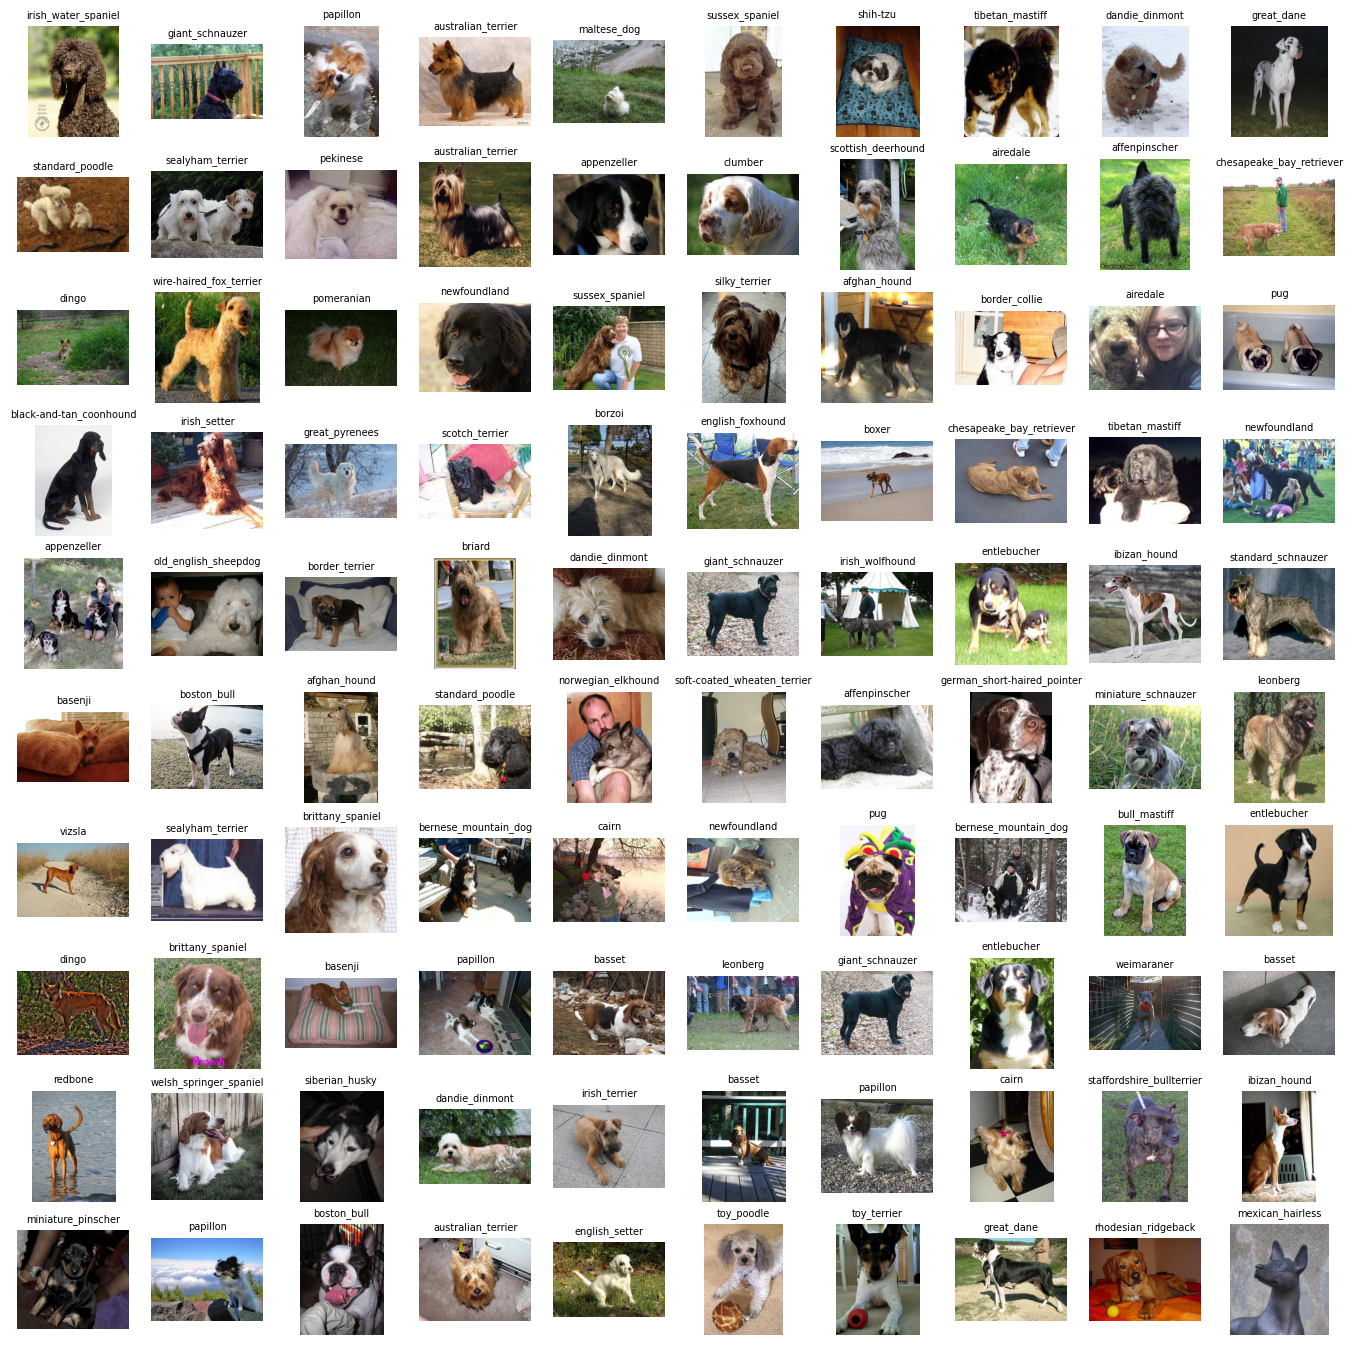

In [ ]:
figure = plt.figure(figsize=(17, 17))
cols, rows = 10, 10
''''''
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dogs), size=(1,)).item() # Случайный индекс из датасета
    sample = dogs.loc[sample_idx, ['id', 'breed']] # Обращение по такому индексу возвращает изображение и метку элемента датасета
    figure.add_subplot(rows, cols, i)
    label = sample['breed']
    plt.title(label, fontsize = 7)
    plt.axis("off")
    img = plt.imread('train/' + str(sample['id']) + '.jpg')
    plt.imshow(img)
plt.show()

In [ ]:
dogs.groupby('breed').size().sort_values()#не так и много дисбаланса

breed
briard                   66
eskimo_dog               66
komondor                 67
brabancon_griffon        67
golden_retriever         67
                       ... 
bernese_mountain_dog    114
entlebucher             115
afghan_hound            116
maltese_dog             117
scottish_deerhound      126
Length: 120, dtype: int64

In [ ]:
def pictsize(num):
  pict = plt.imread('train/' + str(num) + '.jpg')
  return pict.shape
pictsize('000bec180eb18c7604dcecc8fe0dba07')

(375, 500, 3)

In [ ]:
dogs['size'] = dogs['id'].map(pictsize)

In [ ]:
dogs.groupby('size')['id'].nunique().sort_values()#надо будет подгонять под 512*512

size
(102, 120, 3)       1
(369, 250, 3)       1
(368, 615, 3)       1
(368, 470, 3)       1
(368, 436, 3)       1
                 ... 
(334, 500, 3)     172
(500, 333, 3)     363
(500, 375, 3)     615
(333, 500, 3)    1033
(375, 500, 3)    2647
Name: id, Length: 2656, dtype: int64

In [ ]:
def isbig(size):
  return size[0]>512 or size[1]>512
dogs['big'] = dogs['size'].map(isbig)
big=dogs[dogs['big']==1].reset_index()
dogs.groupby('big')['id'].count()

big
False    9698
True      524
Name: id, dtype: int64

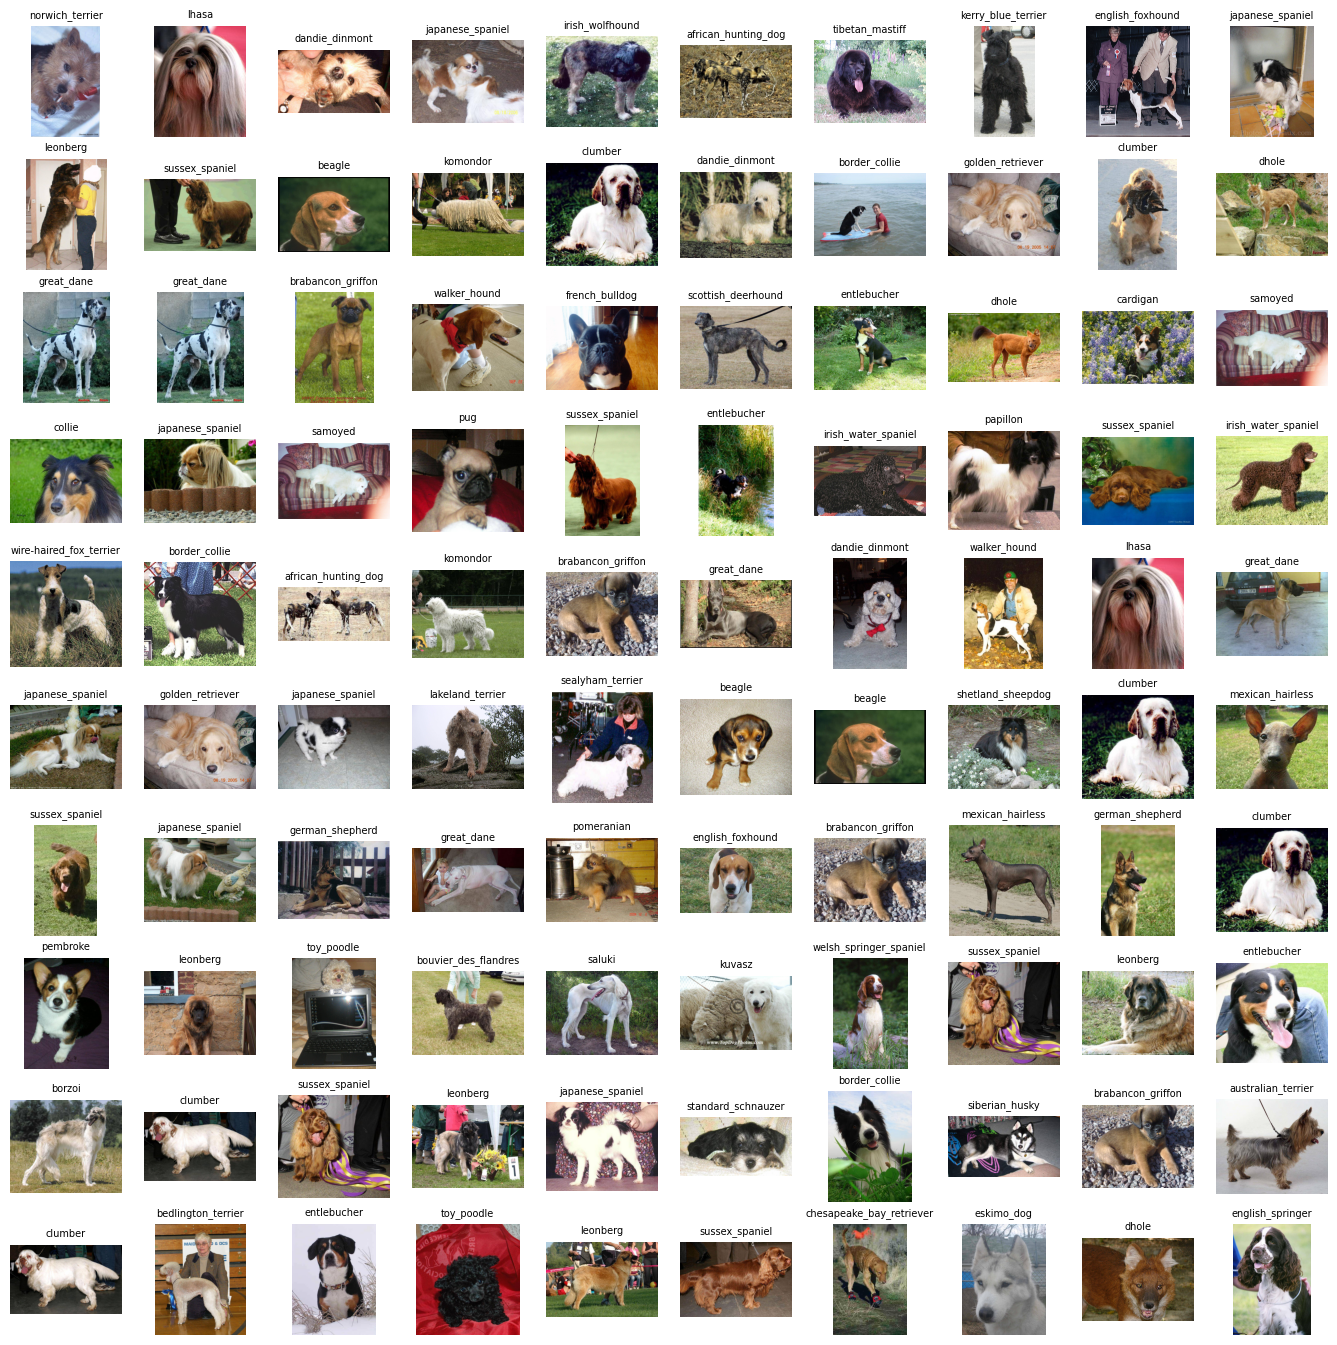

In [ ]:
figure = plt.figure(figsize=(17, 17))
cols, rows = 10, 10
''''''
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(big), size=(1,)).item() # Случайный индекс из датасета
    sample = big.loc[sample_idx, ['id', 'breed']] # Обращение по такому индексу возвращает изображение и метку элемента датасета
    figure.add_subplot(rows, cols, i)
    label = sample['breed']
    plt.title(label, fontsize = 7)
    plt.axis("off")
    img = plt.imread('train/' + str(sample['id']) + '.jpg')
    plt.imshow(img)
plt.show()

вроде мало отличаются от собак меньших размеров, поэтому можно бы просто делать resize

note to self а мб попробовать с паддингом, чтоб соотношения сторон не трогать?

In [ ]:
sample

id       19299f2fae5ea3f66ee61b38d97167d0
breed                    english_springer
Name: 56, dtype: object

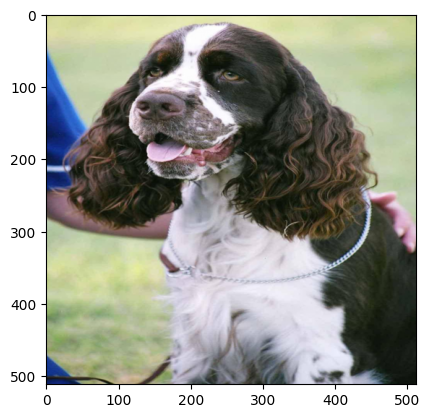

In [ ]:
img = plt.imread('train/' + str(sample['id']) + '.jpg')
image = Resize((512,512), antialias=True)(ToTensor()(img))
plt.imshow(np.moveaxis(image.numpy(),0,-1))

In [ ]:
(labels=='border_collie').argmax(), labels[16]

(16, 'border_collie')

теперь делаем датасет

In [131]:
class dogsdata(Dataset):

    def __init__(self, df, mode, transform=None):
        self.df = df
        self.mode = mode
        self.transform = transform
        if mode == 'train': self.labels = self.df['breed'].sort_values().unique()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.mode +'/' + self.df.loc[idx, 'id'] + '.jpg'
        image = plt.imread(img_name)
        image = Resize((224,224), antialias=True)(ToTensor()(image))
        if self.mode == 'train':
            breed = self.df.loc[idx,'breed']
            label = (self.labels==breed).argmax()
            label = torch.tensor(label)
        else: label = self.df.loc[idx, 'id']

        if self.transform:
            image = self.transform(image)

        image[image>1] = 1
        return {'image': image, 'label': label}

In [46]:
trs = Compose([ RandomApply([RandomHorizontalFlip()]), RandomApply([GaussianBlur(kernel_size=(5, 9))])])

In [47]:
ds = {}
ds['train'], ds['val'] = random_split(dogsdata(dogs,'train' trs), [.9,.1])
dataloader = {x: DataLoader(ds[x], batch_size=64, shuffle=True) for x in ['train','val']}

In [ ]:
for i in range(1000):
  sample_idx = torch.randint(len(ds['train']), size=(1,)).item()
  a = torch.max(ds['train'][sample_idx]['image']).item()
  b = torch.min(ds['train'][sample_idx]['image']).item()
  if b<0 or a>1:
    print('АЛЯРМА')
    print('min ', b)
    print('max ', a)
#blur гад такой делал больше 1

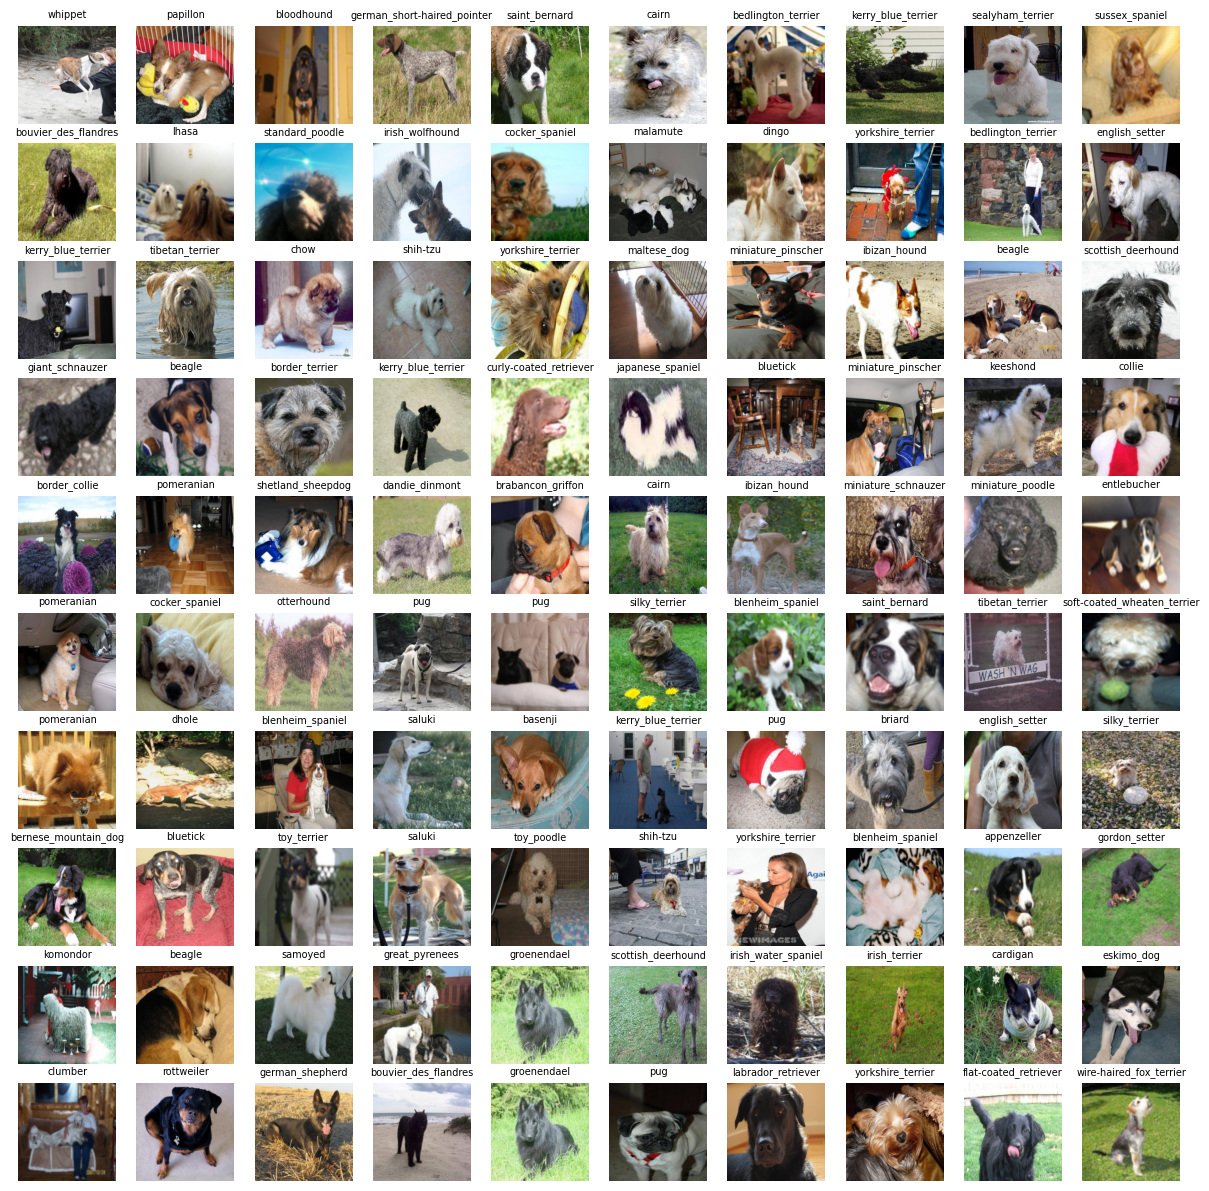

In [48]:
figure = plt.figure(figsize=(15, 15))
cols, rows = 10, 10
''''''
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(ds['train']), size=(1,)).item() # Случайный индекс из датасета
    sample = ds['train'][sample_idx] # Обращение по такому индексу возвращает изображение и метку элемента датасета
    figure.add_subplot(rows, cols, i)
    label = int(sample['label'])
    plt.title(labels[label], fontsize = 7)
    plt.axis("off")
    plt.imshow(np.moveaxis(sample['image'].numpy(),0,-1))
    #print(sample['image'].shape)
plt.show()

#train


In [71]:
from torchvision.models import resnet50, efficientnet_v2_l

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [88]:
model = resnet50(weights='DEFAULT').to(device)

In [89]:
for param in model.parameters():
    param.requires_grad = False

In [144]:
model.fc = nn.Linear(in_features=2048, out_features=120, bias=True).to(device)#fullyconnected is .fc
#this is for resnet

In [83]:
class effrankenstein(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = efficientnet_v2_l(weights='DEFAULT')
        self.act = nn.LeakyReLU(0.2)
        self.hat = nn.Linear(1000, 120)

    def forward(self, x):
        x = self.net(x)
        x = self.act(x)
        logits = self.hat(x)
        return logits

In [84]:
model = effrankenstein().to(device)

In [ ]:
for name, param in model.named_parameters():
    if name[:3] == 'net' : param.requires_grad = False
    else: param.requires_grad = True
    print(name)

In [77]:
def train_loop(dataloader, model, loss_fn, optimizer, lss_train):
    size = len(dataloader.dataset)
    for batch, sample in enumerate(dataloader):
        #move
        X = sample['image'].to(device)
        y = sample['label'].to(device)
        # Получаем предсказания модели для данного батча
        pred = model(X)
        # Вычисляем лосс
        loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        loss.backward()
        # Производим шаг алгоритма оптимизации
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            lss_train.append(loss)

def test_loop(dataloader, model, loss_fn, accs, lss):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for sample in dataloader:
            #move
            X = sample['image'].to(device)
            y = sample['label'].to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    accs.append(100*correct)
    lss.append(test_loss)

In [59]:
loss_fn = nn.CrossEntropyLoss()

In [147]:
learning_rate = .001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-70)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [1,2,3,4], gamma=0.005)
epochs = 5
lss_train = []
lss = []
accs = []
for t in range(epochs):
    print(f"Epoch {t}\n-------------------------------")
    model.train(True)
    train_loop(dataloader['train'], model, loss_fn, optimizer, lss_train)
    model.train(False)
    test_loop(dataloader['val'], model, loss_fn, accs, lss)
    torch.save(model.state_dict(), f"drive/MyDrive/dogs/dog{t}.pt")
    scheduler.step()
print("Done!")

Epoch 0
-------------------------------
loss: 0.527786  [    0/ 9200]
loss: 0.469028  [ 6400/ 9200]
Test Error: 
 Accuracy: 80.2%, Avg loss: 0.730126 

Epoch 1
-------------------------------
loss: 0.223603  [    0/ 9200]
loss: 0.371397  [ 6400/ 9200]
Test Error: 
 Accuracy: 81.5%, Avg loss: 0.707925 

Epoch 2
-------------------------------
loss: 0.223291  [    0/ 9200]
loss: 0.362602  [ 6400/ 9200]
Test Error: 
 Accuracy: 82.3%, Avg loss: 0.690062 

Epoch 3
-------------------------------
loss: 0.228128  [    0/ 9200]
loss: 0.265612  [ 6400/ 9200]
Test Error: 
 Accuracy: 81.9%, Avg loss: 0.707236 

Epoch 4
-------------------------------
loss: 0.105653  [    0/ 9200]
loss: 0.105734  [ 6400/ 9200]
Test Error: 
 Accuracy: 82.3%, Avg loss: 0.713496 

Done!


ну вторая ячейка ниже для своей архитектуры, так что эхэх

In [ ]:
learning_rate = 0.0000005 #по идее это где то на порядок больше предыдущего, ну вот так
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-60)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [1,2,4], gamma=0.06)

In [ ]:
newepochs = 5
for t in range(epochs, epochs+newepochs):
    print(f"Epoch {t}\n-------------------------------")
    model.train(True)
    train_loop(dataloaders['train'], model, loss_fn, optimizer, lss_train)
    model.train(False)
    test_loop(dataloaders['valid'], model, loss_fn, accs, lss)
    torch.save(model.state_dict(), f"drive/MyDrive/dogs/dog{t}.pt")
    scheduler.step()
print("Done!")
epochs+=newepochs

In [ ]:
plt.plot(np.linspace(0, len(lss)-1, len(lss_train)), lss_train)
plt.plot(range(len(lss)), lss)
#plt.plot(range(len(lss)), accs)
#np.savetxt("/content/drive/MyDrive/
#plt.title("loss")
#plt.savefig("/content/drive/MyDrive/
plt.show()

In [148]:
torch.save(model.state_dict(), f"drive/MyDrive/dogs/resdog.pt")#82%

In [87]:
torch.save(model.state_dict(), f"drive/MyDrive/dogs/effdog.pt")#63%

In [93]:
model = model.eval().to(device)
state_dict = torch.load(f"drive/MyDrive/dogs/dog4.pt")#, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [94]:
test_loop(dataloader['val'], model, loss_fn, [],[])

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.707388 



тест на отправку

In [95]:
outf = pd.read_csv('sample_submission.csv')
outf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10357 entries, 0 to 10356
Columns: 121 entries, id to yorkshire_terrier
dtypes: float64(120), object(1)
memory usage: 9.6+ MB


In [96]:
outf.head()

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e       0.008333      0.008333   
1  00102ee9d8eb90812350685311fe5890       0.008333      0.008333   
2  0012a730dfa437f5f3613fb75efcd4ce       0.008333      0.008333   
3  001510bc8570bbeee98c8d80c8a95ec1       0.008333      0.008333   
4  001a5f3114548acdefa3d4da05474c2e       0.008333      0.008333   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0             0.008333  0.008333                        0.008333     0.008333   
1             0.008333  0.008333                        0.008333     0.008333   
2             0.008333  0.008333                        0.008333     0.008333   
3             0.008333  0.008333                        0.008333     0.008333   
4             0.008333  0.008333                        0.008333     0.008333   

   australian_terrier   basenji    basset  ...  toy_poodle  toy_terrier  \
0            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
1            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
2            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
3            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
4            0.008333  0.008333  0.008333  ...    0.008333     0.008333   

     vizsla  walker_hound  weimaraner  welsh_springer_spaniel  \
0  0.008333      0.008333    0.008333                0.008333   
1  0.008333      0.008333    0.008333                0.008333   
2  0.008333      0.008333    0.008333                0.008333   
3  0.008333      0.008333    0.008333                0.008333   
4  0.008333      0.008333    0.008333                0.008333   

   west_highland_white_terrier   whippet  wire-haired_fox_terrier  \
0                     0.008333  0.008333                 0.008333   
1                     0.008333  0.008333                 0.008333   
2                     0.008333  0.008333                 0.008333   
3                     0.008333  0.008333                 0.008333   
4                     0.008333  0.008333                 0.008333   

   yorkshire_terrier  
0           0.008333  
1           0.008333  
2           0.008333  
3           0.008333  
4           0.008333  

[5 rows x 121 columns]

In [105]:
np.array(outf.columns[1:])==labels

True

In [141]:
out = pd.DataFrame(columns = ['id', *labels])

In [118]:
from os import listdir

In [ ]:
ids = [id[:-4] for id in listdir('test/')]
ids

In [123]:
outdogs = pd.DataFrame(ids, columns = ['id'] )
outdogs

id
0      dfc0659b3b6eff35dc50d2501f1ea247
1      5aa4280436034ebb01208a320ecda325
2      188bd471a25447903d80f2ee66c403f8
3      9216c4467e82f86c0c356b08cd46bdb2
4      13d754a5773abf7b3671c1b426fb71df
...                                 ...
10352  4693e3e7303ded00ccd10b1587f03be2
10353  66ab1561f7d0fadbc955dd2f8835f348
10354  b85b25f17411e9d0c10a0ba785a31fe6
10355  19229109053a458524736665c38e7042
10356  fa3e51b3b0dc0e722f1b1877c2e5d8d1

[10357 rows x 1 columns]

In [132]:
ds = dogsdata(outdogs, 'test')
dl = DataLoader(ds, batch_size=64, shuffle=False)

In [152]:
with torch.no_grad():
   for sample in dl:
        X = sample['image'].to(device)
        id = sample['label']
        logits = model(X)
        pred = nn.Softmax(0)(logits)
        pred = pred.cpu()
        newout = pd.DataFrame(pred, columns = labels)
        newout['id'] = id
        out = pd.concat([out, newout])

In [153]:
out

id  affenpinscher  afghan_hound  \
0   dfc0659b3b6eff35dc50d2501f1ea247   5.156278e-11  3.435768e-08   
1   5aa4280436034ebb01208a320ecda325   4.021038e-06  5.804409e-03   
2   188bd471a25447903d80f2ee66c403f8   3.596897e-05  1.085061e-02   
3   9216c4467e82f86c0c356b08cd46bdb2   1.363509e-07  4.968784e-04   
4   13d754a5773abf7b3671c1b426fb71df   5.932737e-10  1.296585e-06   
..                               ...            ...           ...   
48  4693e3e7303ded00ccd10b1587f03be2   7.847078e-03  4.098551e-04   
49  66ab1561f7d0fadbc955dd2f8835f348   1.684071e-11  9.723168e-14   
50  b85b25f17411e9d0c10a0ba785a31fe6   1.003002e-06  6.657330e-09   
51  19229109053a458524736665c38e7042   1.088045e-06  3.742354e-08   
52  fa3e51b3b0dc0e722f1b1877c2e5d8d1   1.774341e-02  5.524945e-05   

    african_hunting_dog      airedale  american_staffordshire_terrier  \
0          9.153647e-12  8.517810e-06                    3.039670e-05   
1          1.099146e-08  4.852648e-04                    2.330669e-04   
2          9.999079e-01  6.337335e-03                    3.176703e-02   
3          1.126035e-06  5.879111e-05                    6.933016e-03   
4          2.554473e-09  5.413609e-06                    2.831256e-01   
..                  ...           ...                             ...   
48         2.995340e-06  5.615219e-05                    3.370008e-08   
49         1.988370e-12  4.581714e-09                    6.249962e-12   
50         1.466714e-06  2.092719e-04                    2.747576e-06   
51         7.073099e-07  6.224743e-06                    9.875242e-05   
52         3.040768e-01  2.131726e-02                    2.347324e-04   

     appenzeller  australian_terrier       basenji        basset  ...  \
0   2.393194e-04        3.434010e-08  1.299805e-08  2.779905e-09  ...   
1   5.773816e-05        5.795699e-05  1.117909e-06  9.019427e-07  ...   
2   8.330569e-02        6.589826e-04  1.678806e-02  1.271488e-04  ...   
3   3.398437e-02        4.889711e-05  4.791246e-05  8.335699e-05  ...   
4   9.222814e-04        2.136340e-07  3.227821e-05  3.551130e-08  ...   
..           ...                 ...           ...           ...  ...   
48  4.991174e-08        1.962900e-04  1.387971e-09  2.259220e-05  ...   
49  3.769212e-11        9.868938e-08  1.055745e-09  7.121559e-10  ...   
50  4.322565e-05        3.154310e-03  8.681149e-01  1.824271e-03  ...   
51  4.551314e-07        4.319895e-04  1.010584e-06  1.013776e-04  ...   
52  5.906725e-05        2.753970e-02  1.791343e-04  1.139889e-03  ...   

      toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0   2.382898e-10  3.055681e-08  6.988218e-08  1.504739e-06  1.205586e-07   
1   9.859153e-01  3.514278e-06  1.092948e-03  3.203607e-05  9.030421e-03   
2   1.642890e-05  3.457186e-05  9.177978e-02  2.932295e-02  1.399862e-01   
3   2.093490e-06  1.080603e-07  4.406862e-01  8.887661e-02  5.077162e-03   
4   3.472659e-08  8.590861e-07  2.729108e-05  2.223544e-05  4.055060e-06   
..           ...           ...           ...           ...           ...   
48  6.778443e-02  7.090524e-07  8.416206e-06  2.430313e-07  8.230365e-05   
49  1.646134e-12  7.067071e-09  5.720809e-11  8.207953e-12  3.159216e-11   
50  3.581587e-06  6.858964e-03  3.526481e-04  1.826564e-02  3.601238e-04   
51  4.388620e-06  7.742412e-06  1.392729e-01  1.697864e-03  4.883467e-04   
52  4.198407e-04  7.265833e-03  3.539869e-03  8.094091e-04  3.362756e-04   

    welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0             3.247442e-08                 2.358982e-10  4.798903e-07   
1             1.213701e-05                 6.604027e-04  9.204018e-04   
2             7.319784e-03                 5.134914e-04  5.144276e-01   
3             2.136183e-01                 2.332212e-05  1.946185e-04   
4             2.368132e-09                 1.518623e-07  4.268862e-03   
..                     ...                          ...           ...   
48            6.649510e-10 

In [155]:
out.to_csv('out.csv', index=False)